In [1]:
import time
start_time = time.time()
import os, sys
import numpy as np
import pandas as pd
import configparser
import pyemu
import matplotlib.pyplot as plt
import inspect
import shutil
import flopy

vs_code_dir = r"D:\Workspace\projects\mississippi\pure_c_pestpp\pestpp"

flopy is installed in D:\anaconda\envs\py36\lib\site-packages\flopy-3.2.13-py3.6.egg\flopy


In [2]:
config = configparser.ConfigParser()
config.read("config.init")

['config.init']

In [3]:
#1) Create a template folder that contains model executable, model input files, and model output files.  
template_ws = os.path.join(".","od_flow_template") # od_flow os one dim flow model
if not(os.path.isdir(template_ws)):
    os.mkdir(template_ws)
else:
    shutil.rmtree(template_ws)
print(os.path.abspath(template_ws))

D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\od_flow_template


FloPy is using the following  executable to run the model: D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\bin\win\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: flow_1d.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/05/31 12:43:58

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/05/31 12:43:58
 Elapsed run time:  0.060 Seconds

  Normal termination of simulation


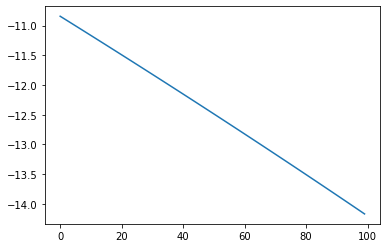

In [4]:
#2) create a simple flow model
from model_setup import generate_1d_model
generate_1d_model() # this is a simple script that setup the 1D flow problem

In [5]:
# Copy the generated model to the template foprintlder
print(os.listdir())
shutil.copytree('model_dataset', os.path.join(template_ws, 'model_dataset'))
shutil.rmtree('model_dataset')


['.ipynb_checkpoints', 'config.init', 'misc_files', 'model_dataset', 'model_setup.py', 'new_od_flow_template', 'one_dim_flow.ipynb', 'PstFrom.log', 'xxxx_tobe_remove_forward_model.py', '__pycache__']


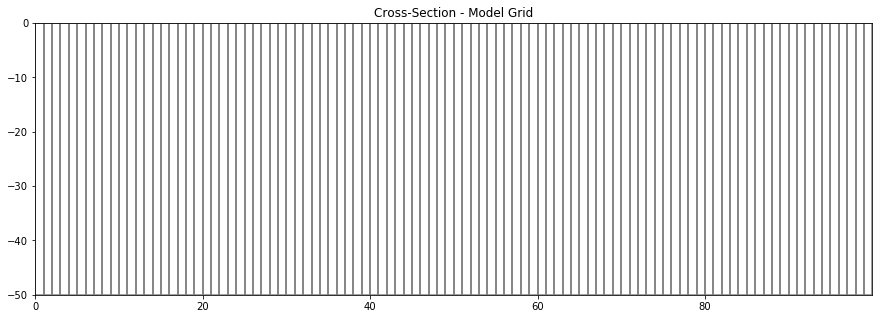

In [6]:
fnam = os.path.join(template_ws, r'model_dataset\flow_1d.nam')
mf = flopy.modflow.Modflow.load(os.path.basename(fnam), model_ws= os.path.dirname(fnam))
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
linecollection = xsect.plot_grid()
t = ax.set_title('Cross-Section - Model Grid')

In [7]:
np.random.seed(42)
corr_scale = 50
nx, ny = mf.nrow, mf.ncol # of cells
N = 50 # number of realizations
m = 5 # number of measurements
refence_realization = 4
delc = mf.dis.delc.array
delr = mf.dis.delr.array

# pyemu allow us to define the spatial structure of grid. This object (sr) will be used later.
sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc )

## 2b) Our model has two input files: index.dat and inputx.csv. The index.csv contains the indices of measurement locations.
#   and inputx.dat has all interpolated values. I like to setup model so that I have only one input file and one output file. 
#   A python script will be used to read and process the input file and apply it to MODFLOW files. In a similar way, modflow output files
#   will be read by the script and merged in one file.

# here we generate a template input file. The input file has the log10 conductivity
inputx = np.zeros_like(delr)
inputx = inputx[np.newaxis, :]
np.savetxt(os.path.join(template_ws, 'inputx.dat'), inputx)

# another input file that will not contain parameters, but just indexces of head measurements.
df_index = pd.DataFrame()
yi = np.linspace(2,ny-2,m) # measurement index
df_index['idx'] = yi
df_index.to_csv(os.path.join(template_ws, 'index.csv'))

In [8]:
script ="""
import os, sys
import numpy as np
import pandas as pd
import flopy
def forward_model():
    # try to delete output file
    try:
        os.remove("heads_out.csv")
    except:
        pass
    # index
    indx = pd.read_csv('index.csv')['idx'].values.astype(int)   
    
    # read input file    
    x = np.loadtxt('inputx.dat')
    x = np.power(10.0, x)
    mf = flopy.modflow.Modflow.load(r'flow_1d.nam', model_ws = 'model_dataset' )
    
    hk = mf.upw.hk.array.copy()
    hk = x[np.newaxis, np.newaxis, :]
    mf.upw.hk = hk
    mf.upw.write_file()

    basefolder = os.getcwd()
    os.chdir("model_dataset")
    os.system("mfnwt.exe flow_1d.nam")
    os.chdir(basefolder)

    hds = flopy.utils.HeadFile(os.path.join('model_dataset', 'flow_1d.hds'))
    wl = hds.get_data(totim=1.0)
    wl = wl.squeeze()
    # model mapping   
    y =wl[indx]
    
    # write model output
    out = pd.DataFrame()
    out['y'] = y
    out.to_csv('heads_out.csv', index_label = 'id')
    
if __name__ == "__main__":
    forward_model()

"""
with open(os.path.join(template_ws, r"forward_model.py"), 'w') as fidw:
    fidw.write(script)

In [9]:
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

# PstFrom to setup the problem.

In [10]:
# Generate a pf object
new_d =  os.path.join(".", "new_"+os.path.basename(template_ws))
pf = pyemu.utils.PstFrom(original_d=template_ws, new_d=new_d,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False,start_datetime="1-1-2018", multi_threads = False)

2021-05-31 12:44:01.820657 starting: opening PstFrom.log for logging
2021-05-31 12:44:01.820657 starting PstFrom process
2021-05-31 12:44:01.821661 starting: setting up dirs
2021-05-31 12:44:01.822662 starting: removing existing new_d 'new_od_flow_template'
2021-05-31 12:44:01.857664 finished: removing existing new_d 'new_od_flow_template' took: 0:00:00.035002
2021-05-31 12:44:01.857664 starting: copying original_d 'od_flow_template' to new_d 'new_od_flow_template'
2021-05-31 12:44:01.917659 finished: copying original_d 'od_flow_template' to new_d 'new_od_flow_template' took: 0:00:00.059995
2021-05-31 12:44:01.919658 finished: setting up dirs took: 0:00:00.097997


In [11]:
# add input file that contains parameters
par_fn = 'inputx.dat'
par_name_base = 'kx'
pargp = 'KH'

v = pyemu.utils.geostats.ExpVario(a=corr_scale,contribution=1.0)
grid_gs = pyemu.utils.geostats.GeoStruct(variograms=v,nugget=0.0)

pf.add_parameters(filenames=par_fn, par_type="grid",
                  par_name_base=par_name_base, pargp=pargp,
                  upper_bound=5., lower_bound=-5, ult_ubound=3.0, ult_lbound=-3,
                  geostruct=grid_gs, transform='none', par_style='direct')

2021-05-31 12:44:01.932660 starting: adding grid type direct style parameters for file(s) ['inputx.dat']
2021-05-31 12:44:01.932660 starting: loading array new_od_flow_template\inputx.dat
2021-05-31 12:44:01.936660 finished: loading array new_od_flow_template\inputx.dat took: 0:00:00.004000
2021-05-31 12:44:01.936660 loaded array 'od_flow_template\inputx.dat' of shape (1, 100)
2021-05-31 12:44:01.939660 starting: writing array-based template file 'new_od_flow_template\inputx.dat.tpl'
2021-05-31 12:44:01.940661 starting: writing template file new_od_flow_template\inputx.dat.tpl for ['kx_inst:0']
2021-05-31 12:44:01.943659 WARNING: get_xy() warning: position of i and j in index_cols not specified, assume (i,j) are final two entries in index_cols.
2021-05-31 12:44:01.965658 finished: writing template file new_od_flow_template\inputx.dat.tpl for ['kx_inst:0'] took: 0:00:00.024997
2021-05-31 12:44:01.965658 finished: writing array-based template file 'new_od_flow_template\inputx.dat.tpl' to

In [12]:
output_file = r'heads_out.csv'
df_out = pd.read_csv(os.path.join(new_d, output_file), index_col=0)
ins_file =output_file + ".ins"
obs_prefix = 'h' ## Note: using capital letter will cause issues
obsgp = 'heads'
hds_df = pf.add_observations(output_file,insfile=ins_file,index_cols="id",
                    use_cols=list(df_out.columns),prefix=obs_prefix, obsgp = obsgp, ofile_sep = ",")


2021-05-31 12:44:02.003660 starting: adding observations from tabular output file
2021-05-31 12:44:02.004661 starting: reading list new_od_flow_template\heads_out.csv
2021-05-31 12:44:02.008660 finished: reading list new_od_flow_template\heads_out.csv took: 0:00:00.003999
2021-05-31 12:44:02.008660 starting: building insfile for tabular output file heads_out.csv
2021-05-31 12:44:02.078656 finished: building insfile for tabular output file heads_out.csv took: 0:00:00.069996
2021-05-31 12:44:02.079656 starting: adding observation from instruction file 'new_od_flow_template\heads_out.csv.ins'
2021-05-31 12:44:02.097660 finished: adding observation from instruction file 'new_od_flow_template\heads_out.csv.ins' took: 0:00:00.018004
2021-05-31 12:44:02.099659 finished: adding observations from tabular output file took: 0:00:00.095999


In [13]:
pf.mod_sys_cmds.append(cmd)
pst = pf.build_pst(version=2)

pe = pf.draw(num_reals=N, sigma_range= 10, use_specsim=True)
pe.to_csv(os.path.join(new_d, 'HKensemble.csv'))
## Select one realization to represent the unknown truth (the actual reference field). From this truth realization choose observations.
x_true = pe._df.iloc[refence_realization].values

noptmax:0, npar_adj:100, nnz_obs:5
2021-05-31 12:44:02.190659 forward_run line:pyemu.os_utils.run(r'D:\anaconda\envs\py36\python.exe forward_model.py')

2021-05-31 12:44:02.213657 starting: drawing realizations
2021-05-31 12:44:02.217658 starting: spectral simulation for grid-scale pars
SpecSim.initialize() summary: full_delx X full_dely: 404 X 404
2021-05-31 12:44:02.293658 starting: SpecSim: drawing 50 realization for group kh__direct with 100 pars, (log) variance 1.0 (sill 1.0)
SpecSim.initialize() summary: full_delx X full_dely: 404 X 404
2021-05-31 12:44:04.473660 finished: SpecSim: drawing 50 realization for group kh__direct with 100 pars, (log) variance 1.0 (sill 1.0) took: 0:00:02.180002
SpecSim.initialize() summary: full_delx X full_dely: 404 X 404
2021-05-31 12:44:04.518661 finished: spectral simulation for grid-scale pars took: 0:00:02.301003
2021-05-31 12:44:04.518661 starting: Drawing non-specsim pars
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
na

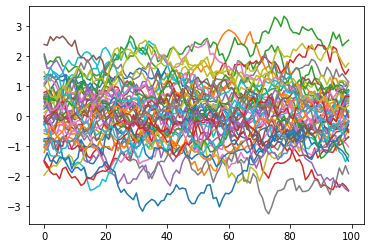

[-0.81703614 -1.93360215 -0.80836959 -0.28117294  0.46618056]
[ 2 26 50 74 98]


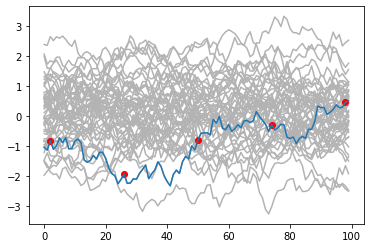

In [14]:
plt.figure()
plt.plot(pe._df.T.values)
plt.show()

ens =  pe._df.values.T
y_ref = ens[:, refence_realization]
y_index = df_index['idx'].astype(int).values # measurement index

print(y_ref[y_index])
print(y_index)

plt.figure()
plt.plot(ens, color = [0.7,0.7,0.7], zorder=1)
plt.plot(ens[:,refence_realization])
plt.scatter(y_index, y_ref[y_index], color = 'r', zorder = 2)
plt.show()

In [15]:
# this a synthatic problem, so we need observations. The observation is generated from the reference realization
inputx = y_ref + np.zeros_like(delr)
inputx = inputx[np.newaxis, :]
np.savetxt(os.path.join(template_ws, 'inputx.dat'), inputx)

In [16]:
# run the model using the synthatic realization
base_folder = os.getcwd()
os.chdir(template_ws)
cmd = sys.executable
cmd = cmd + " " + "forward_model.py"
os.system(cmd)
os.chdir(base_folder)

In [17]:
# read output
df_obs = pd.read_csv(os.path.join(template_ws,'heads_out.csv'))
df_obs

,id,y
0,0,-10.039174
1,1,-11.433419
2,2,-14.787795
3,3,-14.885776
4,4,-14.996939


In [18]:
## use observation from the reference
pst.observation_data['obsval'] = df_obs['y'].values
pst.observation_data['weight'] = 1000 # this is 1/std
pst.observation_data['cycle'] = 0 # ensemble smoother
#pst.observation_data['state_par_link']

pst.parameter_data['cycle'] = 0
pst.parameter_data['parchglim'] = 'relative'
pst.model_input_data['cycle'] = 0
pst.model_output_data['cycle'] = 0

pst.svd_data.eigthresh =  1e-5
pst.pestpp_options['da_add_base']= False
pst.pestpp_options['da_parameter_ensemble']= 'HKensemble.csv'
#pst.pestpp_options['DA_SUBSET_SIZE'] = 50
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['ies_init_lam'] = [1]
pst.pestpp_options['ies_lambda_mults'] = 1
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 1

In [19]:
pst.model_command[0] = pst.model_command[0].replace('python', sys.executable)
pst.write(os.path.abspath(pf.pst.filename), version=2)

noptmax:1, npar_adj:100, nnz_obs:5


## Important check locations of ins and templpe

In [20]:
shutil.copy2(os.path.join(vs_code_dir,"exe","windows","x64","Debug","pestpp-da.exe"),os.path.join(new_d,"pestpp-da.exe"))

'.\\new_od_flow_template\\pestpp-da.exe'

In [21]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)






             pestpp-da: Model Independent Data Assimilation




               Developed by the PEST++ development team





version: 5.0.11

binary compiled on May 27 2021 at 23:09:10



...processing command line: ' pestpp-da.exe od_flow_template.pst'

...using serial run manager



using control file: "od_flow_template.pst"

in directory: "D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_od_flow_template"

on host: "IGSWCAWWLT3972"



processing control file od_flow_template.pst



 >>>> Checking data in cycle 0

...number of adjustable parameters in cycle 0: 100

...number of non-zero weighted observations in cycle 0: 5

num tpl files: 1, num ins files: 1

checking model IO files...done

              starting serial run manager ...



...preparing global parameter ensemble for all parameters across all cycles



  ---  initializing  ---  



  ---  using glm algorithm  ---  

...using REDSVD for truncated svd solve

...maxsing: 10000000


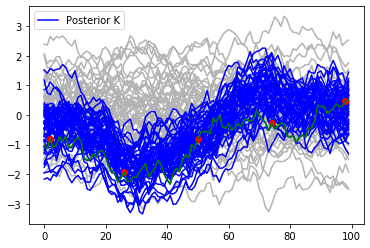

In [22]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')


In [23]:
## Try more iterations for 

In [24]:
pst.pestpp_options['da_num_reals'] = N
pst.pestpp_options['DA_SUBSET_SIZE'] = 10
pst.pestpp_options['ies_init_lam'] = [10]
pst.pestpp_options['ies_lambda_mults'] = [0.1, 1, 10]
pst.pestpp_options['lambda_scale_fac'] = 1
pst.control_data.noptmax = 5 # number of iterations
pst.write(os.path.abspath(pf.pst.filename), version=2)

noptmax:5, npar_adj:100, nnz_obs:5


In [25]:
import subprocess
base_folder = os.getcwd()
os.chdir(new_d)
argv = ["pestpp-da.exe", os.path.basename(pf.pst.filename)]
def run_command(cmd):
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        while True:
            line = p.stdout.readline()
            if not line:
                break
            print(line)    
        exit_code = p.poll()
    return exit_code


run_command(argv)

os.chdir(base_folder)






             pestpp-da: Model Independent Data Assimilation




               Developed by the PEST++ development team





version: 5.0.11

binary compiled on May 27 2021 at 23:09:10



...processing command line: ' pestpp-da.exe od_flow_template.pst'

...using serial run manager



using control file: "od_flow_template.pst"

in directory: "D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_od_flow_template"

on host: "IGSWCAWWLT3972"



processing control file od_flow_template.pst



 >>>> Checking data in cycle 0

...number of adjustable parameters in cycle 0: 100

...number of non-zero weighted observations in cycle 0: 5

num tpl files: 1, num ins files: 1

checking model IO files...done

              starting serial run manager ...



...preparing global parameter ensemble for all parameters across all cycles



  ---  initializing  ---  



  ---  using glm algorithm  ---  

...using REDSVD for truncated svd solve

...maxsing: 10000000


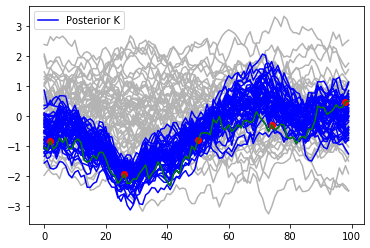

In [26]:
posterior_par = pd.read_csv(os.path.join(new_d, template_ws+".global.0.pe.csv"))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(ens, color = [0.7,0.7,0.7], zorder=1, label = 'Prior K')
handles, labels = ax.get_legend_handles_labels()
display = []
display.append(len(labels))

ax.plot(ens[:,refence_realization], 'g', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(len(labels))

ax.scatter(y_index, y_ref[y_index], color = 'r', zorder = 3)
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

del(posterior_par['real_name'])
ax.plot(posterior_par.values.T, color = 'b', label = 'Posterior K')
handles, labels = ax.get_legend_handles_labels()
display.append(display[-1] + len(labels))

ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best')

In [27]:
sys.path.append(r"..")
import rec_util 
import rec_util
ws = r"D:\Workspace\projects\mississippi\manuscripts\pestppda_paper\notebooks\one_dim_flow\new_od_flow_template"
fname = r"od_flow_template.rec"

fname = os.path.join(ws, fname)
rec = rec_util.RecFile(fname= os.path.join(new_d, template_ws+".rec"))

